In [1]:
import math
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import functional as F
from torch.nn import Module
from torch.nn import MultiheadAttention
from torch.nn import ModuleList
from torch.nn.init import xavier_uniform_
from torch.nn import Dropout
from torch.nn import Linear
from torch.nn import LayerNorm, BatchNorm1d
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from scipy import stats
from typing import Dict, List, Optional, Tuple
import numpy as np
import subprocess
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
from IPython import display
from ipywidgets import  interactive, IntSlider
from data import *
from interpret.chefer import *


# KDE

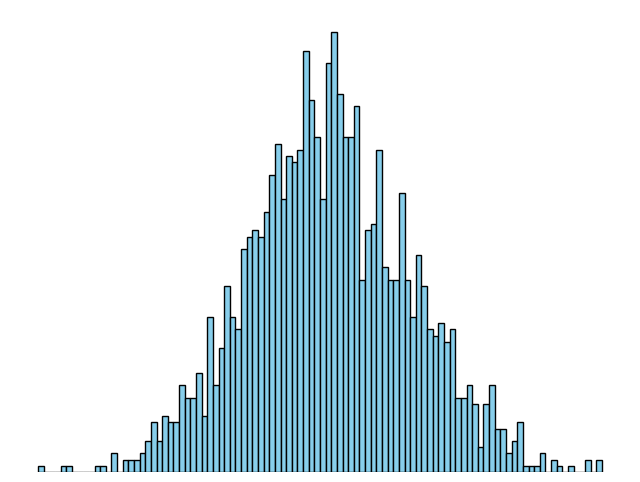

In [7]:
data = np.random.normal(1, 0.5, size=(2000, 2))
# Create the histogram without axes, ticks, and numbers
plt.figure(figsize=(8, 6))  # Set figure size
plt.hist(data[:, 0], bins=100, color='skyblue', edgecolor='black')  # Plot histogram

# Remove axes, ticks, and numbers
plt.axis('off')

# Show the plot
plt.show()

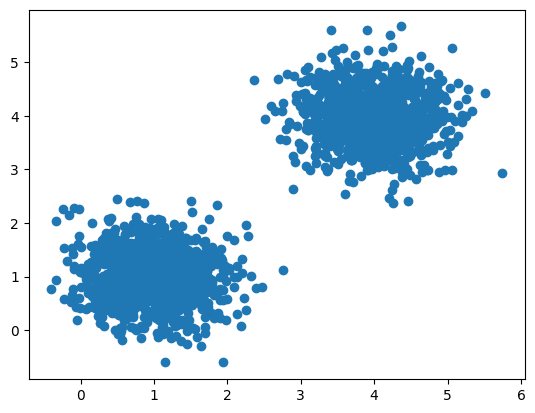

In [3]:
data = np.random.normal(1, 0.5, size=(1000, 2))
data = np.concatenate((data, np.random.normal(4,0.5 ,size=(1000, 2))))
plt.scatter(data[:,0], data[:,1])


(array([ 1.,  0.,  3.,  4.,  2.,  1.,  7.,  6.,  6., 10., 14., 17., 17.,
        25., 25., 29., 17., 39., 35., 37., 50., 39., 46., 40., 53., 50.,
        44., 47., 39., 45., 35., 33., 29., 30., 19., 21., 20., 16.,  6.,
         8.,  4.,  7.,  9.,  5.,  5.,  1.,  3.,  0.,  1.,  0.,  1.,  0.,
         1.,  1.,  2.,  7.,  3.,  7.,  8., 11., 12., 11., 10., 13., 20.,
        22., 30., 39., 32., 47., 42., 42., 55., 56., 41., 43., 46., 57.,
        47., 45., 40., 26., 31., 24., 22., 20., 20., 18., 16.,  4.,  9.,
         4.,  4.,  2.,  2.,  5.,  0.,  1.,  0.,  1.]),
 array([-0.43889522, -0.3795595 , -0.32022378, -0.26088806, -0.20155234,
        -0.14221662, -0.0828809 , -0.02354518,  0.03579054,  0.09512626,
         0.15446198,  0.2137977 ,  0.27313342,  0.33246914,  0.39180486,
         0.45114058,  0.5104763 ,  0.56981202,  0.62914775,  0.68848347,
         0.74781919,  0.80715491,  0.86649063,  0.92582635,  0.98516207,
         1.04449779,  1.10383351,  1.16316923,  1.22250495,  1.281840

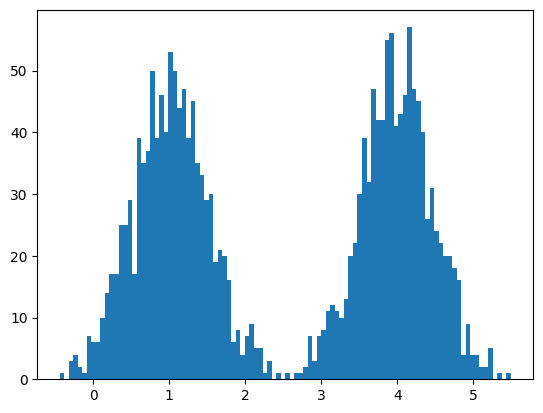

In [4]:
plt.hist(data[:,0], bins=100)

In [5]:
print("Before Reshape for Scipy:", data.shape)
data = data.T
print("After Reshape:", data.shape)

Before Reshape for Scipy: (2000, 2)
After Reshape: (2, 2000)


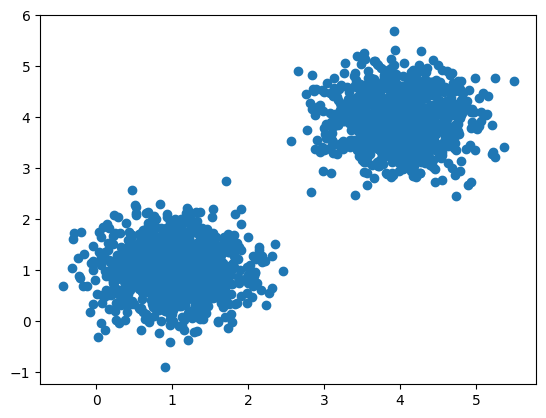

In [6]:
plt.scatter(data[0,:], data[1,:])

In [7]:
kernel = stats.gaussian_kde(data)


In [8]:
X, Y = np.mgrid[0:5:0.1, 0:5:0.1]
points = np.vstack([X.ravel(), Y.ravel()])
Z = kernel(points)
print(Z.shape)
print(points.shape)

(2500,)
(2, 2500)


In [9]:
X = X.reshape(50,50)
Y = Y.reshape(50,50)
Z = Z.reshape(50,50)
print(Z.shape)

(50, 50)


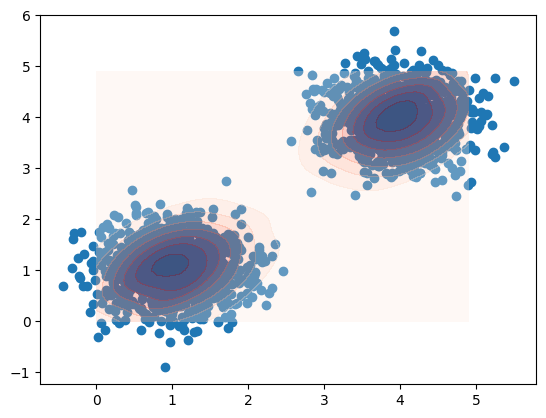

In [10]:

plt.scatter(data[0,:], data[1,:])
plt.contourf(X, Y, Z, cmap='Reds', alpha=0.3)

In [27]:
print(X.shape)
print(Z.shape)
print(Z.max())
print(X[25,:].max())
print(X[25,:].shape)

(50, 50)
(50, 50)
0.1930149228811174
2.5
(50,)


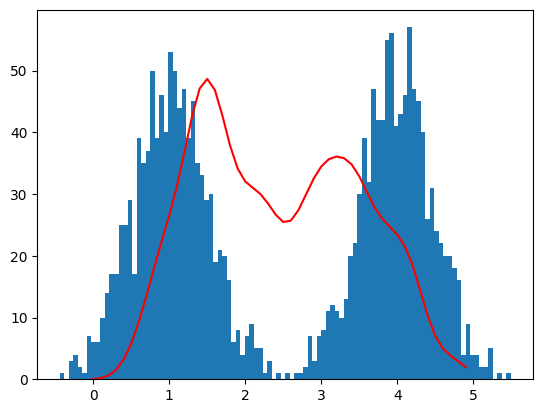

In [30]:
plt.hist(data[0,:], bins=100)
# x = np.linspace(0,5,50) 
# z = kernel(x)
plt.plot(X[:,0], 2500 * Z[25,:], color='red')

# Visualization

In [2]:
# returns a tuple (signals,cams)
def interpret_dataset(interpreter, test_loader):
    # get back the cams, and corresponding signals
    batches = []
    cams = []
    labels = []
    for batch, label in test_loader:
        batches.append(batch)
        cam = interpreter.get_cam(batch, class_index=label)
        cams.append(cam)
        labels.append(label)
        # print(label)
    cams = torch.cat(cams)
    batches = torch.cat(batches)
    labels = torch.cat(labels)
    return batches, cams, labels

# get back the cams for the indices in the prediction set generated
# note that the inputs must still be batched
def interpret_predictions(interpreter, input, prediction_set):
    predicted_cams = []
    for i in range(prediction_set.size()[0]):
        cam = interpreter.get_cam(input, prediction_set[i])
        predicted_cams.append(cam)
    return torch.cat(predicted_cams)

In [18]:
def plot_signal_attentions(x,y,dydx,axs,axs_no=0, title_font_size=10, norm=None):
    '''
    Plot the attention scores on the EEG and EOG signals
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    
    # Create a continuous norm to map from data points to colors
    if norm == None:
        norm = plt.Normalize(dydx.min(), dydx.max())
    # norm = plt.Normalize(dydx.min(), dydx.max())
    lc = LineCollection(segments, cmap='Reds', norm=norm) #, norm=norm)
    # Set the values used for colormapping
    lc.set_array(dydx)
    lc.set_linewidth(2)

    line = axs[axs_no].add_collection(lc)
    axs[axs_no].set_title(f'Channel {axs_no}', fontsize=title_font_size)
    axs[axs_no].set_xlabel(f'Time',fontsize = title_font_size - 4)
    axs[axs_no].xaxis.set_tick_params(labelbottom=False)
    axs[axs_no].yaxis.set_tick_params(labelleft=False)
    
    # Hide X and Y axes tick marks
    axs[axs_no].set_xticks([])
    axs[axs_no].set_yticks([])
    axs[axs_no].set_xlim(x.min(), x.max())
    axs[axs_no].set_ylim(y.min()-0.2,y.max()+0.2)

    return line 


# NEEDS TO BE a 1 x C x T signal tensor
# Take in signal : ndarray C x T
# cam: ndarray C x T
def visualize_signal(signal, cam, nCols=4, title=""):
    nChannels = cam.shape[0]
    nRows = nChannels // nCols
    t = np.arange(0, cam.shape[1], 1)
    # four column channel plots
    fig, ax = plt.subplots(nRows, nCols, figsize=(32,16))
    ax = ax.reshape(-1)
    common_norm = plt.Normalize(cam.min(), cam.max())
    line = None
    for i in range(nChannels):
        line = plot_signal_attentions(t, signal[i], cam[i], ax, i, norm=common_norm)
        
    fig.colorbar(line, ax=ax, shrink=0.7)
    plt.suptitle(title, fontsize=16)
    plt.savefig("presentation.png")
    plt.show()

def visualize_signal_no_show(signal, cam, nCols=4, title=""):
    nChannels = cam.shape[0]
    nRows = nChannels // nCols
    t = np.arange(0, cam.shape[1], 1)
    # four column channel plots
    fig, ax = plt.subplots(nRows, nCols, figsize=(40,20))
    ax = ax.reshape(-1)
    common_norm = plt.Normalize(cam.min(), cam.max())
    for i in range(nChannels):
        plot_signal_attentions(t, signal[i], cam[i], ax, i, norm=common_norm)
    plt.suptitle(title, fontsize=16)

# cams of prediction set should be a len(pred_set) x C x T
# all inputs are ndarrays
def visualize_prediction_set(signal, cams_of_prediction_set, prediction_set):
    nCams = cams_of_prediction_set.shape[0] - 1
    select_data = IntSlider(min=0, max=nCams, step=1, value=0, description="Class Index")
  
    def update_plot(class_no):
        display.clear_output(wait=True)
        visualize_signal_no_show(signal, cams_of_prediction_set[class_no], title=f'Class {prediction_set[class_no]}')
    
    int_plot = interactive(update_plot, class_no=select_data)
    return int_plot
    

In [5]:
# my model hyperparameters
emb_size = 256
depth = 6 
dropout = 0.5
num_heads = 8
patch_kernel_length = 11  # cqi = 15 - UNUSED
stride = 11  # cqi = 8 - UNUSED

model = STTransformer(emb_size=emb_size, 
                                depth=depth,
                                n_classes=6, 
                                channel_length=2000,
                                dropout=dropout, 
                                num_heads=num_heads,
                                kernel_size=11, 
                                stride=11,
                                kernel_size2=11,
                                stride2=11)
model.load_state_dict(torch.load(f"saved_weights/st_transformer_conformal_IIIC_nbs{normalize_by_sample()}.pt"))
model = model.cuda()
# my training hyperparameters
sampling_rate = 200
batch_size = 500 # may be too memory intensive depending on the conformity score...
num_workers = 32
# get the data
train_loader, test_loader, val_loader, cal_loader = prepare_IIIC_cal_dataloader(batch_size=batch_size, num_workers=num_workers)


# get interpreter
interpreter = STTransformerInterpreter(model=model)


107560 13445 35740 13445
216 27 72 27
Cuda Enabled!


In [6]:
signals, cams, labels = interpret_dataset(interpreter, test_loader)

In [6]:
# print(signals.size())
# print(cams.size())
signals = signals.detach().cpu().numpy()
cams = cams.detach().cpu().numpy()
t = np.arange(0,cams.shape[2], 1)
print(t.shape)

(2000,)


In [7]:
print(signals.shape)
print(cams.shape)

(35740, 16, 2000)
(35740, 16, 2000)


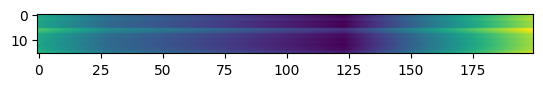

In [8]:
plt.imshow(cams[0,:, 400:600])

In [ ]:
print(signals.max())

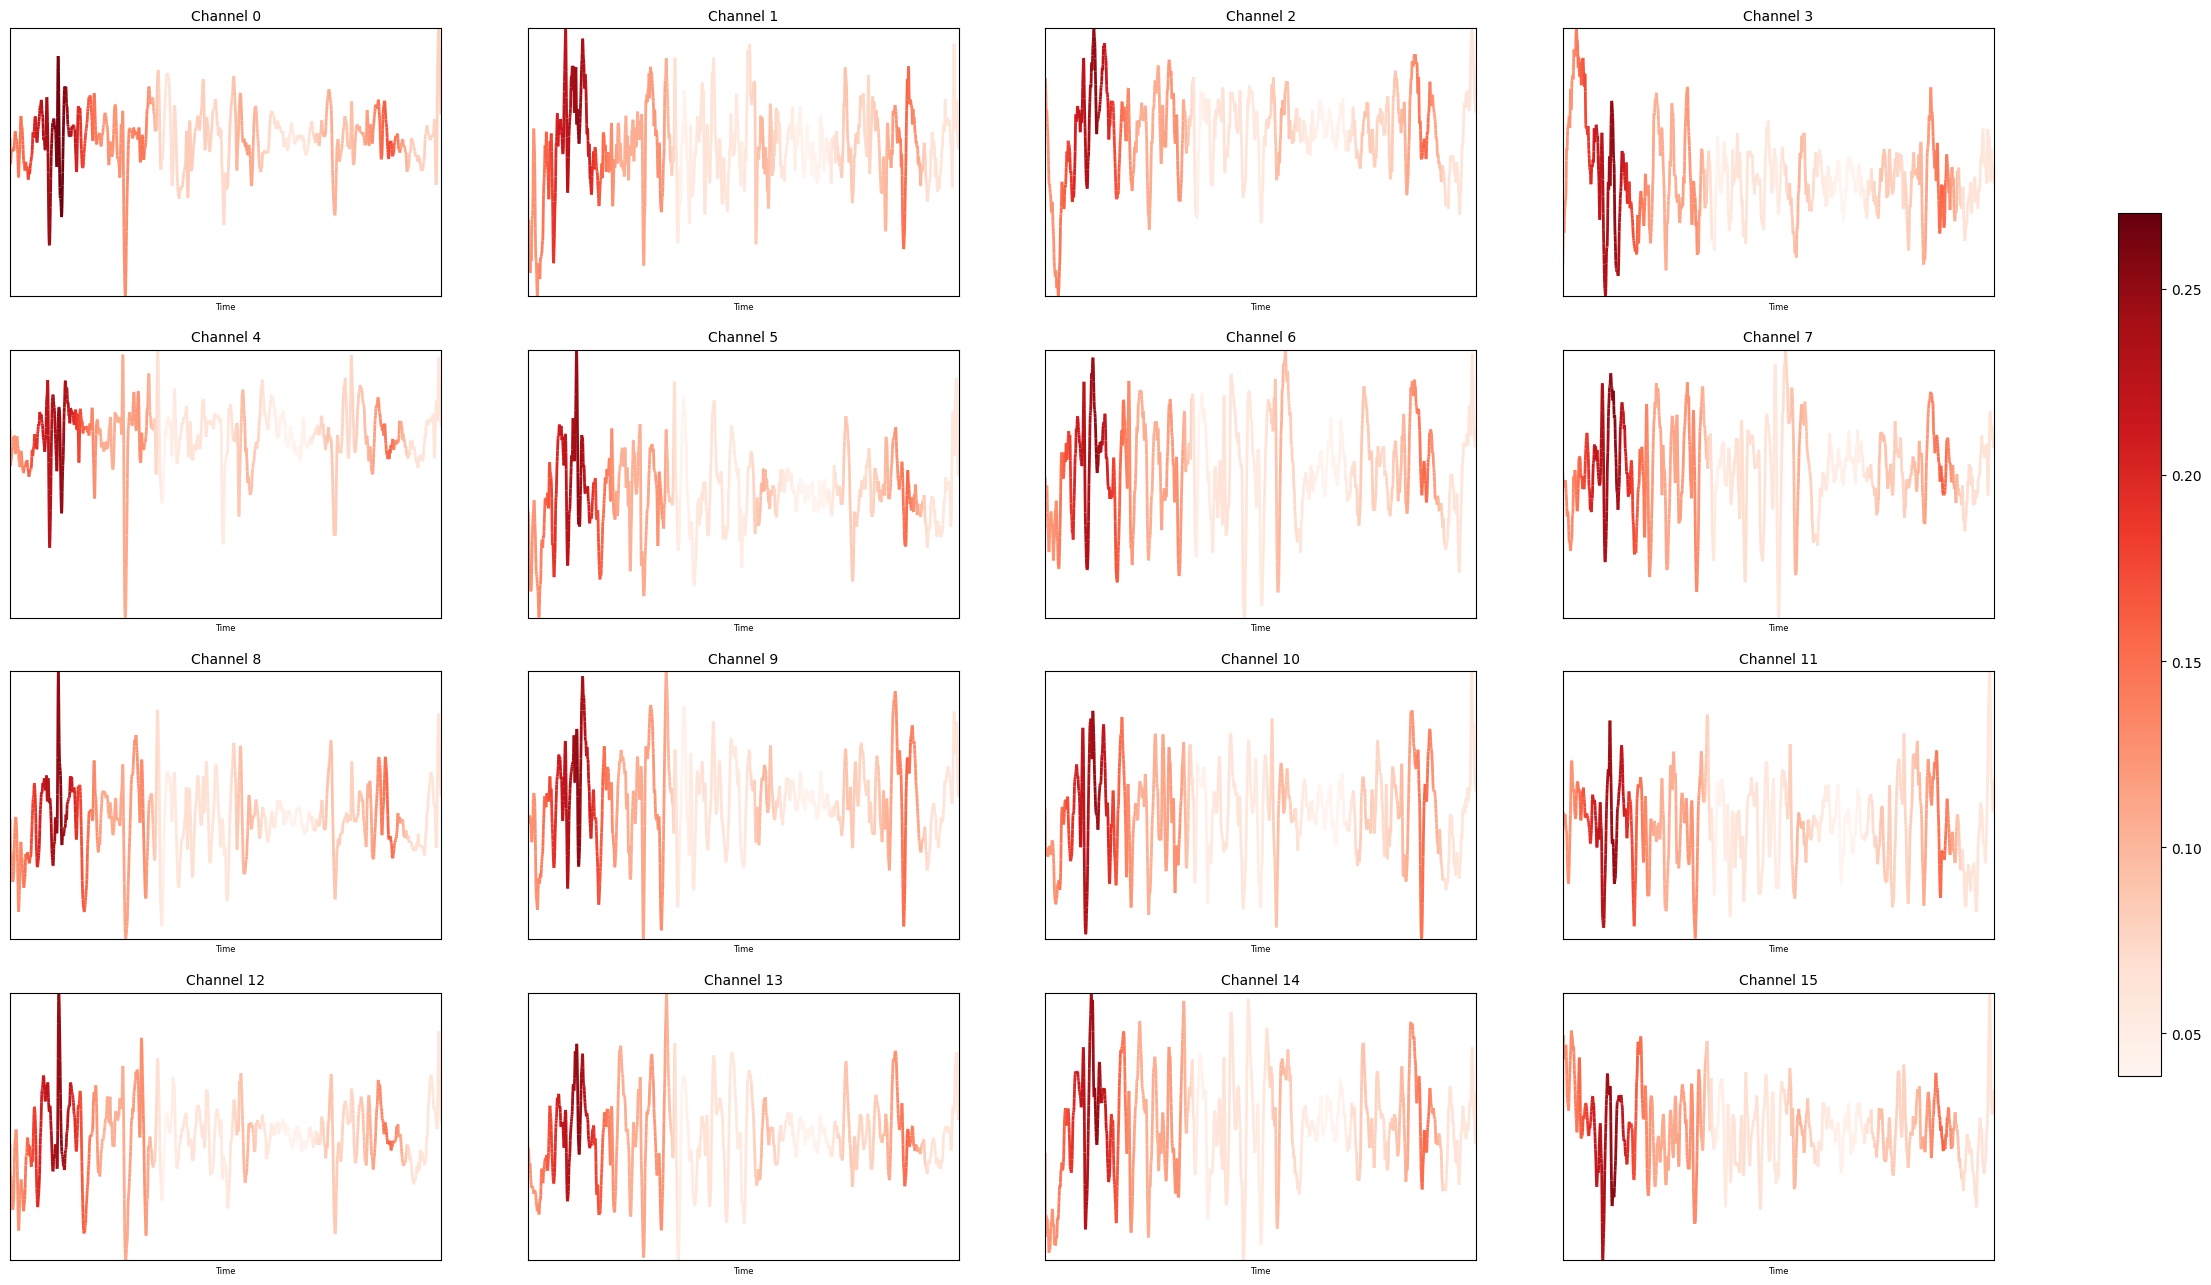

In [24]:
visualize_signal(signals[20], cams[20])
# plt.savefig("presentation.png")

In [19]:
cams_pred = interpret_predictions(interpreter, torch.from_numpy(signals[0]).unsqueeze(0), prediction_set=torch.tensor([0,1,2,3,4,5]))
print(cams.shape)
print(labels[0])

(35740, 16, 2000)
tensor(0)


In [21]:
visualize_prediction_set(signals[0], cams_pred.cpu().numpy(), prediction_set=torch.tensor([0,1,2,3,4,5]) )

interactive(children=(IntSlider(value=0, description='Class Index', max=5), Output()), _dom_classes=('widget-i…

In [7]:
import gc
from road.imputations import *
# initializes an object that computes all calibration scores in PyTorch such that it's parallelizable
# note that interpreter has a model object.
class InterpretableCalibrationScore(ABC):
    def __init__(self, interpreter : STTransformerInterpreter):
        self.interpreter = interpreter
     
    # need this for the calibration scores
    # returns a N x 1 torch tensor of all scores per class_index
    @abstractmethod
    def cal_score(self, input, class_index):
        pass 

    # need this for the scoring function used in the prediction sets
    # must return a N x C torch tensor of all scores per class
    @abstractmethod
    def score(self, input):
        pass


class SoftMax(InterpretableCalibrationScore):
    def cal_score(self, input, class_index):
        # in principle they should have the same device and we detach to prevent memory leaks from autograd (I still don't entirely understand why that works)
        return self.interpreter.model(input.to(self.interpreter.device)).softmax(1).squeeze().gather(1, class_index.to(self.interpreter.device).unsqueeze(1)).squeeze().detach()
    def score(self, input):
        return self.interpreter.model(input.to(self.interpreter.device)).softmax(1).squeeze().detach()

# program cumulative softmax
class CumulativeSoftMax(InterpretableCalibrationScore):
    def cal_score(self, input, class_index):
        # get softmax scores across entire batch
        softmax_scores = self.interpreter.model(input.to(self.interpreter.device)).softmax(1).squeeze().detach()
        # sort them in descending order with respect to their own batches
        sorted_softmax_scores = torch.sort(softmax_scores, descending=True).values
        
        # get cumulative sum of sorted_softmax_scores
        # and then get the respective class index of cumulatively summed scores
        cal_scores = torch.cumsum(sorted_softmax_scores, dim=1).gather(1, class_index.to(self.interpreter.device).unsqueeze(1))

        # B x 1 tensor of calibration scores 
        return cal_scores.squeeze().detach()
    
    def score(self, input):
        # get softmax scores across entire batch
        softmax_scores = self.interpreter.model(input.to(self.interpreter.device)).softmax(1).detach()
        # sort them in descending order with respect to their own batches
        sorted_softmax_scores = torch.sort(softmax_scores, descending=True).values

        # get cumulative sum of sorted_softmax_scores
        scores = torch.cumsum(sorted_softmax_scores, dim=1)
        
        # B x C tensor of calibration scores
        return scores.squeeze().detach()

# GradCam++ Explainability Score Idea 
class SoftMaxDrop(InterpretableCalibrationScore):
    def cal_score(self, input, class_index):
        # get original softmax score
        default_softmax = 0
        with torch.no_grad():
            default_softmax = self.interpreter.model(input.to(self.interpreter.device)).softmax(1)
        if class_index == None:
            class_index = torch.argmax(default_softmax, axis=-1)
        # get cam inputted softmax score
        cam_input = self.interpreter.get_cam_on_image(input, class_index = class_index, method="linear")
        # np_img, cam_input = interpreter.visualize(input, class_index=class_index, show=False)
        # cam_input = cam_input * np_img
        
        interpreted_softmax = self.interpreter.model(cam_input.to(self.interpreter.device)).softmax(1).detach()
        # print(interpreted_softmax)
        # compute some differnence for the true class difference
        score = default_softmax - interpreted_softmax     # smaller difference == greater conformity
        # get the class_indices we want
        score = score.gather(1, class_index.to(self.interpreter.device).unsqueeze(1))
       
        # GREATER CONFIDENCE DROP == CAM IS MORE EXPLAINABLE == GREATER CONFORMITY OF HIGHLIGHTED REGION IN MODEL
        # CONFIDENCE DROP IS POSITIVE RIGHT NOW
        return score.detach()
    
    def score(self, input):
        og_softmax = 0
        with torch.no_grad():
            og_softmax = self.interpreter.model(input.to(self.interpreter.device)).softmax(1)
        interpreted_softmaxes_across_classes = torch.empty(input.size()[0], 0).to(self.interpreter.device)
        for c in range(og_softmax.size()[1]):
            cam = self.interpreter.get_cam_on_image(input, class_index = c, method='linear') # get cam-weighted image w/r to a possible class predictions
            interpreted_softmax = self.interpreter.model(cam.to(self.interpreter.device)).softmax(1)[:,c] # get corresponding softmax confidence to class
            # compute all softmax scores we care about w/r to each class!
            interpreted_softmaxes_across_classes = torch.cat((interpreted_softmaxes_across_classes, interpreted_softmax.unsqueeze(1)), dim=1)
        
        score = og_softmax - interpreted_softmaxes_across_classes
        # GREATER CONFIDENCE DROP == CAM IS MORE EXPLAINABLE == GREATER CONFORMITY OF HIGHLIGHTED REGION IN MODEL
        # CONFIDENCE DROP IS POSITIVE RIGHT NOW
        return score.detach()

# most relevant k pixels masked (removed) confidence drop from ROAR (without the retraining!)
class MORF(InterpretableCalibrationScore):
    def cal_score(self, input, class_index):
        input = input.to(self.interpreter.device) # should just run on the device of the interpreter class.
        # get original softmax score
        default_softmax = 0
        with torch.no_grad():
            default_softmax = self.interpreter.model(input.to(self.interpreter.device)).softmax(1)

        alphas = torch.tensor([.20, .40, .60, .80]) # hardcoded for now, q level?
        nSignals = input.size()[0]
        nPixels = input[0].view(-1).size()[0] # get total number of pixels
        # get cam mask
        cam = self.interpreter.get_cam(input, class_index = class_index, method="linear")
        # flatten came first
        cam = cam.view(nSignals,-1)
        avg_softmax_drop = torch.zeros(default_softmax.size()).to(self.interpreter.device)
        for alpha in alphas:
            q_level =  (torch.ceil((nPixels + 1) * (1 - alpha)) / nPixels).to(self.interpreter.device)
            kth_pixel_value = torch.quantile(cam, q_level, dim=1, interpolation="lower").to(self.interpreter.device)
            # mask all that is above the kth value
            masked_imgs = (cam < kth_pixel_value.unsqueeze(1)).view(input.size()) * input # unsqueeze because to match dims, need to unsqueeze
            # throw it back into the model and get a new matrix of softmax scores
            interpreted_softmax = self.interpreter.model(masked_imgs).softmax(1)
            avg_softmax_drop += (default_softmax - interpreted_softmax) / len(alphas)

        # get the class_indices we want
        avg_softmax_drop = avg_softmax_drop.gather(1, class_index.to(self.interpreter.device).unsqueeze(1))
       
        # GREATER CONFIDENCE DROP == CAM IS MORE EXPLAINABLE == GREATER CONFORMITY OF HIGHLIGHTED REGION IN MODEL
        # CONFIDENCE DROP IS POSITIVE RIGHT NOW
        # detach to reduce vram usage
        return avg_softmax_drop.detach()
    
    def score(self, input):
        input = input.to(self.interpreter.device)
        og_softmax = 0
        with torch.no_grad():
            og_softmax = self.interpreter.model(input.to(self.interpreter.device)).softmax(1)
        alphas = torch.tensor([.20, .40, .60, .80]) # hardcoded for now, q level?
        avg_softmax = torch.zeros(og_softmax.size()).to(self.interpreter.device)
        for c in range(og_softmax.size()[1]):
            nSignals = input.size()[0]
            nPixels = input[0].view(-1).size()[0] # get total number of pixels
            # get cam mask
            cam = self.interpreter.get_cam(input, class_index = c, method="linear")
            # flatten came first
            cam = cam.view(nSignals,-1)
            for alpha in alphas:
                q_level =  torch.ceil((nPixels + 1) * (1 - alpha)) / nPixels
                kth_pixel_value = torch.quantile(cam, q_level.to(self.interpreter.device), dim=1, interpolation="lower").to(self.interpreter.device)
                # mask all that is above the kth value, we use < s.t big values are set to 0
                masked_imgs = (cam < kth_pixel_value.unsqueeze(1)).view(input.size()) * input # unsqueeze because to match dims, need to unsqueeze
                # throw it back into the model and get a new matrix of softmax scores
                interpreted_softmax = self.interpreter.model(masked_imgs).softmax(1)[:,c]
            
                avg_softmax[:,c] += (interpreted_softmax) / len(alphas) # should a 1D vector of softmaxes across each class

        # GREATER CONFIDENCE DROP == CAM IS MORE EXPLAINABLE == GREATER CONFORMITY OF HIGHLIGHTED REGION IN MODEL
        # CONFIDENCE DROP IS POSITIVE RIGHT NOW

        score = og_softmax - avg_softmax
        return score.detach()



class ROAD(InterpretableCalibrationScore):
    def cal_score(self, input, class_index):
        # Compute Original Softmax Scores for Batch
        default_softmax = 0
        with torch.no_grad():
            default_softmax = self.interpreter.model(input.to(self.interpreter.device)).softmax(1)
        imputer = NoisyLinearImputer()
        alphas = torch.tensor([.20, .40, .60, .80]) # hardcoded for now, q level?
        nSignals = input.size()[0]
        nPixels = input[0].view(-1).size()[0] # get total number of pixels
        # get cam mask
        cam = self.interpreter.get_cam(input, class_index = class_index, method="linear")
        # flatten came first
        cam = cam.view(nSignals,-1)
        avg_softmax_drop = torch.zeros(default_softmax.size()).to(self.interpreter.device)
        for alpha in alphas:
            q_level =  (torch.ceil((nPixels + 1) * (1 - alpha)) / nPixels).to(self.interpreter.device)
            kth_pixel_value = torch.quantile(cam, q_level, dim=1, interpolation="lower").to(self.interpreter.device)
            # mask all that is above the kth value
            mask= (cam < kth_pixel_value.unsqueeze(1)).view(input.size())  # unsqueeze because to match dims, need to unsqueeze
            # Use NoisyLinearImputer to Impute the Masked Region On the Original Image
            # unsqueeze for color channel lol
            imputed_imgs = imputer.batched_call(input.unsqueeze(1), mask)
            imputed_imgs = imputed_imgs.squeeze().to(self.interpreter.device) # squeeze it back into normal shape
            # throw it back into the model and get a new matrix of softmax scores
            interpreted_softmax = self.interpreter.model(imputed_imgs).softmax(1)
            avg_softmax_drop += (default_softmax - interpreted_softmax) / len(alphas)

        
        avg_softmax_drop = avg_softmax_drop.gather(1, class_index.to(self.interpreter.device).unsqueeze(1))
        return avg_softmax_drop.detach()


    def score(self, input):
        input = input.to(self.interpreter.device)
        og_softmax = 0
        with torch.no_grad():
            og_softmax = self.interpreter.model(input.to(self.interpreter.device)).softmax(1)
        alphas = torch.tensor([.20, .40, .60, .80]) # hardcoded for now, q level?
        avg_softmax = torch.zeros(og_softmax.size()).to(self.interpreter.device)
        imputer = NoisyLinearImputer()
        for c in range(og_softmax.size()[1]):
            nSignals = input.size()[0]
            nPixels = input[0].view(-1).size()[0] # get total number of pixels
            # get cam mask
            cam = self.interpreter.get_cam(input, class_index = c, method="linear")
            # flatten came first
            cam = cam.view(nSignals,-1)
            for alpha in alphas:
                q_level =  torch.ceil((nPixels + 1) * (1 - alpha)) / nPixels
                kth_pixel_value = torch.quantile(cam, q_level.to(self.interpreter.device), dim=1, interpolation="lower").to(self.interpreter.device)
                # mask all that is above the kth value
                mask = (cam < kth_pixel_value.unsqueeze(1)).view(input.size()) # unsqueeze because to match dims, need to unsqueeze
                imputed_imgs = imputer.batched_call(input.unsqueeze(1) ,mask)
                imputed_imgs = imputed_imgs.squeeze()
                # throw it back into the model and get a new matrix of softmax scores
                interpreted_softmax = self.interpreter.model(imputed_imgs.view(input.size())).softmax(1)[:,c]
            
                avg_softmax[:,c] += (interpreted_softmax) / len(alphas) # should a 1D vector of softmaxes across each class

        # GREATER CONFIDENCE DROP == CAM IS MORE EXPLAINABLE == GREATER CONFORMITY OF HIGHLIGHTED REGION IN MODEL
        # CONFIDENCE DROP IS POSITIVE RIGHT NOW

        score = og_softmax - avg_softmax
        return score.detach()

def likelihood_ratio(input, kde_cal, kde_test) -> np.ndarray:
    return (kde_test(input) / kde_cal(input))

def sum_likelihood_ratios(cal_dataloader, kde_cal, kde_test):
    sum = []
    # sum them all up
    for batch, label in cal_dataloader:
        sum.append(likelihood_ratio(batch, kde_cal, kde_test))
    return np.sum(np.concatenate(sum))

def calibration_weight(input, sum_cal_likelihoods ,kde_cal, kde_test) -> torch.Tensor:
    cal_wt = likelihood_ratio(input, kde_cal, kde_test) / sum_cal_likelihoods
    return torch.from_numpy(cal_wt) # must be tensor to multiply with output of calibration score

def test_weight(input, sum_cal_likelihoods, kde_cal, kde_test) -> torch.Tensor:
    test_wt = likelihood_ratio(input, kde_cal, kde_test)
    test_wt /= (sum_cal_likelihoods + likelihood_ratio(input, kde_cal, kde_test))
    return torch.from_numpy(test_wt)

class Covariate(ABC):
    def __init__(self, interpreter : STTransformerInterpreter, cal_density_estimator, test_density_estimator):
        self.interpreter = interpreter
    @abstractmethod
    def cal_score(self, input, class_index):
        pass
    @abstractmethod
    def score(self, input):
        pass

class SoftMaxCovariate(Covariate):
    def __init__(self, interpreter : STTransformerInterpreter, 
                 cal_density_estimator, test_density_estimator, dataloader):
        
        self.interpreter = interpreter
        self.cal_density_estimator = cal_density_estimator
        self.test_density_estimator = test_density_estimator
        self.softmax = SoftMax(interpreter)
        self.sum_cal_likelihoods = sum_likelihood_ratios(dataloader, self.cal_density_estimator, self.test_density_estimator)

    def cal_score(self, input, class_index):
        cal_score = self.softmax.cal_score(input, class_index)
        return calibration_weight(input, self.sum_cal_likelihoods, self.cal_density_estimator, self.test_density_estimator) * cal_score
    # every input should in principle 
    def score(self, input):
        score = self.softmax.score(input)
        return test_weight(input, self.sum_cal_likelihoods, self.cal_density_estimator, self.test_density_estimator).unsqueeze(1) * score


class CumulativeSoftMaxCovariate(Covariate):

    def __init__(self, interpreter : STTransformerInterpreter, cal_density_estimator, test_density_estimator, dataloader):
        self.interpreter = interpreter
        self.cal_density_estimator = cal_density_estimator
        self.test_density_estimator = test_density_estimator
        self.cum_softmax = CumulativeSoftMax(interpreter)
        self.sum_cal_likelihoods = sum_likelihood_ratios(dataloader, self.cal_density_estimator, self.test_density_estimator)

    def cal_score(self, input, class_index):
        cal_score = self.cum_softmax.cal_score(input, class_index)
        return calibration_weight(input, self.sum_cal_likelihoods, self.cal_density_estimator, self.test_density_estimator) * cal_score
    
    def score(self, input):
        score = self.cum_softmax.score(input)
        return test_weight(input, self.sum_cal_likelihoods, self.cal_density_estimator, self.test_density_estimator).unsqueeze(1) * score

class ConformalCalibrator():
    def __init__(self, interpreter, method="softmax", kde_cal = None, kde_test = None, cal_dataloader=None):
        self.scorer = SoftMax(interpreter)
        self.method = method # for printing
        self.covariate = False
        if method == "softmax":
            self.scorer= SoftMax(interpreter)
        elif method == "cum_softmax":
            self.scorer = CumulativeSoftMax(interpreter)
        elif method == "softmax_drop":
            self.scorer = SoftMaxDrop(interpreter)
        elif method == "ROAD":
            self.scorer = ROAD(interpreter)
        elif method =="MORF":
            self.scorer = MORF(interpreter)
        elif method == "cov_softmax":
            self.covariate = True # for the sake of just keeping track of wtf is going on
            self.scorer = SoftMaxCovariate(interpreter, kde_cal, kde_test, cal_dataloader)
        elif method == "cov_cum_softmax":
            self.covariate = True
            self.scorer = CumulativeSoftMaxCovariate(interpreter, kde_cal, kde_test, cal_dataloader)
        else: 
            print("Error Need to Define a Scoring Function")
            exit(-1)

    # q_hat
    def calibrate(self, calibration_dataloader, alpha):
        # compute sorted calibration scores 
        conformity_scores = torch.tensor([]).to(self.scorer.interpreter.device)
        for signal, label in calibration_dataloader:
            # calibration scores should return a torch tensor
            score = self.scorer.cal_score(input=signal, class_index = label) # should return a scalar
            # print(score.size())
            conformity_scores = torch.cat((conformity_scores, score))
            gc.collect()
            with torch.no_grad():
                torch.cuda.empty_cache() # empty the cache before iterating
        
        # flatten and sort
        conformity_scores = conformity_scores.view(-1)
        # use the conformal prediction equation to calculate q_hat score
        # get quantile defined by alpha
        n = conformity_scores.size()[0]
        assert(int(1/alpha) < n) # throw error if alpha is too small

        q_level =  torch.ceil(torch.tensor((n + 1) * (1 - alpha))) / n
        q_level = 1 - q_level # for conformity score not nonconformity score

        q_hat = torch.quantile(conformity_scores.to(q_level.dtype), q_level.to(self.scorer.interpreter.device), interpolation='lower')
        # detach and set to cpu to save VRAM
        return q_hat.detach().cpu()
 
    # get prediction set in torch
    def predict_set(self, input,  q_hat):
        scores = self.scorer.score(input)
        prediction_set = scores > q_hat
        return prediction_set.detach()


In [8]:
# from uq.conformal import *
# from uq.conformity import *
# from uq.covariate import *
import uq.kde
attn_kde_cal = uq.kde.AttentionDensityEstimator(interpreter, cal_loader, nEpochs=50, saved_path="saved_weights/attn_kde_cal_IIIC.pt")
attn_kde_test = uq.kde.AttentionDensityEstimator(interpreter, test_loader, nEpochs=50, saved_path="saved_weights/attn_kde_test_IIIC.pt")
cp = ConformalCalibrator(interpreter, method="cov_softmax", cal_dataloader=cal_loader, kde_cal = attn_kde_cal, kde_test = attn_kde_test)

torch.Size([13445, 21])
torch.Size([13445, 21, 32])
torch.Size([13445, 8])
torch.Size([35740, 21])
torch.Size([35740, 21, 32])
torch.Size([35740, 8])


In [33]:
pred_set = cp.predict_set(signals[0].unsqueeze(0), q_hat=2.112155428335427e-08)

In [34]:
print(pred_set.size())
print(pred_set)

torch.Size([1, 6])
tensor([[ True,  True, False,  True, False, False]])


In [35]:
pred_set = torch.nonzero(pred_set.squeeze()).squeeze()


In [36]:
print(pred_set.size())

torch.Size([3])


In [37]:
cams_pred = interpret_predictions(interpreter, signals[0].unsqueeze(0), prediction_set=pred_set)

In [38]:
visualize_prediction_set(signals[0], cams_pred.cpu().numpy(), prediction_set=pred_set)

interactive(children=(IntSlider(value=0, description='Class Index', max=2), Output()), _dom_classes=('widget-i…

In [39]:
print("Ground Truth:", labels[0])

tensor(0)


In [52]:
print(len(signals))

35740


In [19]:
sample = 0
pred_set = cp.predict_set(signals[sample].unsqueeze(0), q_hat=2.112155428335427e-08)
pred_set = torch.nonzero(pred_set.squeeze()).squeeze()
cams_pred = interpret_predictions(interpreter, signals[sample].unsqueeze(0), prediction_set=pred_set)
visualize_prediction_set(signals[sample], cams_pred.cpu().numpy(), prediction_set=pred_set)


interactive(children=(IntSlider(value=0, description='Class Index', max=2), Output()), _dom_classes=('widget-i…

In [14]:
print(cams[0].size())

torch.Size([16, 2000])


In [20]:
sample = 0
pred_set = torch.tensor([0,1,2,3,4,5])
cams_pred = interpret_predictions(interpreter, signals[sample].unsqueeze(0), prediction_set=pred_set)
visualize_prediction_set(signals[sample], cams_pred.cpu().numpy(), prediction_set=pred_set)

interactive(children=(IntSlider(value=0, description='Class Index', max=5), Output()), _dom_classes=('widget-i…

In [54]:
print("Ground Truth:", labels[sample])

Ground Truth: tensor(5)


In [ ]:
plt.imshow(signals[0])